In [1]:
import numpy as np
from matplotlib import pyplot as plt
import csv
import math

In [2]:
def get_dataset(filename):
    dataset = None
    results = []
    with open(filename) as csvfile:
        reader = csv.reader(csvfile,quoting=csv.QUOTE_NONNUMERIC)
        for row in reader: 
            results.append(row[1:])
    dataset = np.array(results[1:])
    return dataset

get_dataset('bodyfat.csv')

array([[12.6   ,  1.0708, 23.    , ..., 32.    , 27.4   , 17.1   ],
       [ 6.9   ,  1.0853, 22.    , ..., 30.5   , 28.9   , 18.2   ],
       [24.6   ,  1.0414, 22.    , ..., 28.8   , 25.2   , 16.6   ],
       ...,
       [28.3   ,  1.0328, 72.    , ..., 31.3   , 27.2   , 18.    ],
       [25.3   ,  1.0399, 72.    , ..., 30.5   , 29.4   , 19.8   ],
       [30.7   ,  1.0271, 74.    , ..., 33.7   , 30.    , 20.9   ]])

In [3]:
dataset = get_dataset('bodyfat.csv')
dataset.shape

(252, 16)

In [236]:
def print_stats(dataset, col):
    length=len(dataset)
    target= dataset[:,col]
    mean=sum(target)/len(target)
    sd=(sum((x - mean) ** 2 for x in target) / (len(target) - 1))**0.5
    print('{}\n{:.2f}\n{:.2f}'.format(length, mean,sd))
    pass
print_stats(dataset, 1)

252
1.06
0.02


In [19]:
def regression(dataset, cols, betas):
    mse = None
    y=dataset[:,0]
    x=dataset[:,cols]
    x = np.hstack((np.ones((len(dataset), 1)), x))    
    mse=np.sum(np.square(x@betas-y))/len(dataset)
    return mse

regression(dataset, cols=[2,3], betas=[0,0,0])
regression(dataset, cols=[2,3,4], betas=[0,-1.1,-.2,3])

11859.17408611111

In [64]:
def gradient_descent(dataset, cols, betas):
    grads = None
    g=[]
    y=dataset[:,0]
    x=dataset[:,cols]
    x = np.hstack((np.ones((len(dataset), 1)), x))
    for i in range(len(betas)):
        grad=((x@betas-y)@x[:,i])*2/len(y) 
        g.append(grad)
    grads=np.array(g)
    return grads

gradient_descent(dataset, cols=[2,3], betas=[0,0,0])

array([  -37.87698413, -1756.37222222, -7055.35138889])

In [100]:
def iterate_gradient(dataset, cols, betas, T, eta):   
    for i in range(1, T + 1):
        betas=betas-(gradient_descent(dataset,cols,betas)*eta)
        mse=regression(dataset,cols,betas)
        print(i, *map(lambda x: f'{x:.2f}', [mse, *betas]))
    pass
iterate_gradient(dataset, cols=[1,8], betas=[400,-400,300], T=10, eta=1e-4)

1 423085332.40 394.45 -405.84 -220.18
2 229744495.73 398.54 -401.54 163.14
3 124756241.68 395.53 -404.71 -119.33
4 67745350.04 397.75 -402.37 88.82
5 36787203.39 396.11 -404.09 -64.57
6 19976260.50 397.32 -402.82 48.47
7 10847555.07 396.43 -403.76 -34.83
8 5890470.68 397.09 -403.07 26.55
9 3198666.69 396.60 -403.58 -18.68
10 1736958.93 396.96 -403.20 14.65


In [108]:
def compute_betas(dataset, cols):
    betas = None
    mse = None
    y=dataset[:,0]
    x=dataset[:,cols]
    x = np.concatenate([np.ones((x.shape[0], 1)), x], axis=1)
    betas=(np.linalg.inv(x.T@x))@(x.T@y)
    mse=regression(dataset,cols,betas)
    return (mse, *betas)
compute_betas(dataset, cols=[1,2])

(1.4029395600144425,
 441.3525943611676,
 -400.59549537035286,
 0.009892204825494133)

In [125]:
def predict(dataset, cols, features):
    result = None
    t=compute_betas(dataset,cols)
    betas=t[1:]
    result=betas[0] 
    for i in range(len(features)):
        result+=features[i]*betas[i+1]
    return result
predict(dataset, cols=[1,2], features=[1.0708, 23])

12.622458629580077

In [267]:
def synthetic_datasets(betas, alphas, X, sigma):
    z=np.random.normal(0,sigma,len(X))
    linear=np.ones((X.shape[0], 1))
    for i in range(len(X)):
        linear[i]=betas[0] + betas[1] * X[i][0] + z[i]
    linear= np.concatenate([linear, X], axis=1)
    quadratic=np.ones((X.shape[0], 1))
    for i in range(len(X)):
        quadratic[i]=alphas[0]+alphas[1]*(X[i][0])**2+z[i]
    quadratic= np.concatenate([quadratic, X], axis=1)
    
    return linear, quadratic

synthetic_datasets(np.array([0,2]), np.array([0,1]), np.array([[4]]), 1)

(array([[7.72150984, 4.        ]]), array([[15.72150984,  4.        ]]))

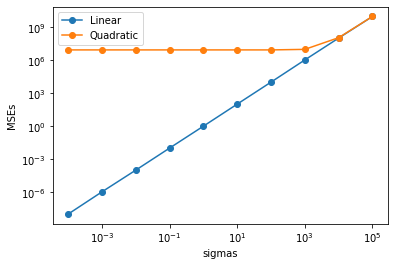

In [372]:
def plot_mse():
    from sys import argv
    if len(argv) == 2 and argv[1] == 'csl':
        import matplotlib
        matplotlib.use('Agg')

    X = np.random.randint(-100,101, size=(1000,1))
    alpha=np.array([0,2])
    beta=np.array([0,1])
    sigmas = np.logspace(-4, 5, num=10)
    linear_result=[]
    quadratic_result=[]
    for sigma in sigmas:
        l,q=synthetic_datasets(alpha,beta,X,sigma)
        linear=compute_betas(l,[1])
        quadratic=compute_betas(q,[1])
        linear_result.append(linear[0])
        quadratic_result.append(quadratic[0])

    fig1 = plt.plot(sigmas, linear_result, "-o", label = "Linear")
    fig2 = plt.plot(sigmas, quadratic_result, "-o", label = "Quadratic")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("sigmas")
    plt.ylabel("MSEs")
    plt.legend()
    plt.savefig('mse.pdf')


plot_mse()